# Whale Vicinity Scoring — Binance Wallet (April 1st & April 2025) — Phase 1

In [7]:
from neo4j import GraphDatabase
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

NEO4J_BOLT_URI = "bolt://192.168.0.5:7687"
NEO4J_AUTH     = ("neo4j", "PotatoDTND12!")
driver = GraphDatabase.driver(NEO4J_BOLT_URI, auth=NEO4J_AUTH)

APRIL_START_EPOCH = 1743476400
APRIL_END_EPOCH   = 1746068400
APRIL1_START      = 1743476400
APRIL1_END        = 1743562800

WHALE_ADDR = "0x28c6c06298d514db089934071355e5743bf21d60"

print("Setup OK.")


Setup OK.


In [8]:

def _run_single(s, q, **params):
    res = s.run(q, **params)
    rec = res.single()
    return rec.data() if rec else None

def _default_stats_dict():
    return {"n_total": 0, "mean_score": None, "std_score": None, "anomaly_rate": 0.0,
            "anom_min": None, "anom_max": None, "norm_min": None, "norm_max": None}

def one_minus_ws(df_scores):
    if df_scores.empty or df_scores["label"].nunique() < 2:
        return {"one_minus_ws": np.nan, "ws": np.nan, "word": "low-separation"}
    a = df_scores.loc[df_scores.label==1, "score"].astype(float).values
    b = df_scores.loc[df_scores.label==0, "score"].astype(float).values
    if len(a)==0 or len(b)==0:
        return {"one_minus_ws": np.nan, "ws": np.nan, "word": "low-separation"}
    ws = wasserstein_distance(a, b)
    lo = float(np.nanmin(np.concatenate([a,b])))
    hi = float(np.nanmax(np.concatenate([a,b])))
    rng = max(hi - lo, 1e-12)
    ws_norm = ws / rng
    sim = 1.0 - max(0.0, min(1.0, ws_norm))
    if ws_norm >= 0.4:  word = "high-separation"
    elif ws_norm >= 0.2: word = "moderate-separation"
    else:                word = "low-separation"
    return {"one_minus_ws": sim, "ws": ws_norm, "word": word}

def sci(x, sig=6):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return "n/a"
    if x == 0:
        return f"{0:.{sig}f} × 10^0"
    exp = int(np.floor(np.log10(abs(x))))
    mant = x / (10**exp)
    return f"{mant:.{sig}f} × 10^{exp}"

def prose_for_period(period_label, s_whale, s_global, sim_info):
    def fmt(x):
        return "n/a" if x is None else (f"{x:.4f}" if isinstance(x,(float,int,np.floating)) else str(x))
    local = s_whale.get("anomaly_rate") or 0.0
    global_ = s_global.get("anomaly_rate") or 0.0
    lift = (local / global_) if (global_ and global_ > 0) else float('inf')
    if np.isfinite(lift) and lift >= 2.0:
        conc_word = "concentration"
    else:
        overlap = False
        try:
            if s_whale["anom_max"] is not None and s_whale["norm_min"] is not None:
                overlap = s_whale["anom_max"] >= s_whale["norm_min"]
        except Exception:
            overlap = True
        conc_word = "concentration" if overlap else "dilution"
    return f"""**{period_label}**
Anomaly rate (whale vicinity): {fmt(local)}  |  Global: {fmt(global_)}  |  Lift: {("∞" if not np.isfinite(lift) else f"{lift:.1f}x")}
Anomaly scores: min {fmt(s_whale['anom_min'])}, max {fmt(s_whale['anom_max'])}
Normal  scores: min {fmt(s_whale['norm_min'])}, max {fmt(s_whale['norm_max'])}
1 − Wasserstein similarity (anomaly vs normal): {fmt(sim_info.get('one_minus_ws'))}  —  {sim_info.get('word','low-separation')}
(normalized WS distance = {fmt(sim_info.get('ws'))}; higher WS ⇒ more separation)
Interpretation: neighbors show behaviors akin to liquidity movements, leading to a {conc_word} of anomaly flags with compressed score bands near the whale.
"""

def plot_hist(df, title):
    if df.empty:
        print("No sample to plot for", title); return
    plt.figure(figsize=(8,5))
    plt.hist(df.loc[df.label==0, "score"], bins=80, alpha=0.6, label="Normal (label=0)", density=True)
    plt.hist(df.loc[df.label==1, "score"], bins=80, alpha=0.6, label="Anomaly (label=1)", density=True)
    plt.axvline(0, linestyle="--", linewidth=0.8)
    plt.title(title); plt.xlabel("IsolationForest decision score"); plt.ylabel("Density"); plt.legend(); plt.show()


In [9]:

# ----- Phase 1 Cypher helpers -----
def stats_whale_phase1(start_epoch, end_epoch, whale=WHALE_ADDR):
    q = """
MATCH (w:Wallet {address: $whale})

OPTIONAL MATCH (w)-[:SENT]->(tx1:Transaction)
WHERE tx1.timestamp >= $startEpoch AND tx1.timestamp < $endEpoch
  AND tx1.label IS NOT NULL AND tx1.scoring IS NOT NULL
WITH w, collect(DISTINCT tx1) AS sent

OPTIONAL MATCH (w)<-[:RECEIVED_BY]-(tx2:Transaction)
WHERE tx2.timestamp >= $startEpoch AND tx2.timestamp < $endEpoch
  AND tx2.label IS NOT NULL AND tx2.scoring IS NOT NULL
WITH w, sent, collect(DISTINCT tx2) AS recv

WITH sent, recv
WITH sent + recv AS txs
WITH txs, size(txs) AS total,
     reduce(a = 0, t IN txs | a + CASE WHEN toInteger(t.label) = 1 THEN 1 ELSE 0 END) AS anom_cnt
WITH txs, total, CASE WHEN total > 0 THEN toFloat(anom_cnt)/total ELSE 0.0 END AS anomaly_rate
UNWIND (CASE WHEN size(txs)=0 THEN [NULL] ELSE txs END) AS tx
WITH anomaly_rate, total, tx
RETURN
  total                                    AS n_total,
  avg(toFloat(tx.scoring))                 AS mean_score,
  stDev(toFloat(tx.scoring))               AS std_score,
  anomaly_rate                             AS anomaly_rate,
  min(CASE WHEN toInteger(tx.label)=1 THEN toFloat(tx.scoring) END) AS anom_min,
  max(CASE WHEN toInteger(tx.label)=1 THEN toFloat(tx.scoring) END) AS anom_max,
  min(CASE WHEN toInteger(tx.label)=0 THEN toFloat(tx.scoring) END) AS norm_min,
  max(CASE WHEN toInteger(tx.label)=0 THEN toFloat(tx.scoring) END) AS norm_max
"""
    with driver.session() as s:
        rec = _run_single(s, q, startEpoch=start_epoch, endEpoch=end_epoch, whale=whale)
    return rec or _default_stats_dict()

def stats_global_phase1(start_epoch, end_epoch):
    q = """
MATCH (tx:Transaction)
WHERE tx.timestamp >= $startEpoch AND tx.timestamp < $endEpoch
  AND tx.label IS NOT NULL AND tx.scoring IS NOT NULL
RETURN
  count(tx)                                                 AS n_total,
  avg(toFloat(tx.scoring))                                  AS mean_score,
  stDev(toFloat(tx.scoring))                                AS std_score,
  toFloat(sum(CASE WHEN toInteger(tx.label)=1 THEN 1 ELSE 0 END))/count(tx) AS anomaly_rate,
  min(CASE WHEN toInteger(tx.label)=1 THEN toFloat(tx.scoring) END)         AS anom_min,
  max(CASE WHEN toInteger(tx.label)=1 THEN toFloat(tx.scoring) END)         AS anom_max,
  min(CASE WHEN toInteger(tx.label)=0 THEN toFloat(tx.scoring) END)         AS norm_min,
  max(CASE WHEN toInteger(tx.label)=0 THEN toFloat(tx.scoring) END)         AS norm_max
"""
    with driver.session() as s:
        rec = _run_single(s, q, startEpoch=start_epoch, endEpoch=end_epoch)
    return rec or _default_stats_dict()

def sample_scores_whale_phase1(start_epoch, end_epoch, whale=WHALE_ADDR, limit_per_class=20000):
    q = """
MATCH (w:Wallet {address: $whale})
OPTIONAL MATCH (w)-[:SENT]->(tx1:Transaction)
WHERE tx1.timestamp >= $startEpoch AND tx1.timestamp < $endEpoch
  AND tx1.label IS NOT NULL AND tx1.scoring IS NOT NULL
WITH w, collect(DISTINCT tx1) AS sent
OPTIONAL MATCH (w)<-[:RECEIVED_BY]-(tx2:Transaction)
WHERE tx2.timestamp >= $startEpoch AND tx2.timestamp < $endEpoch
  AND tx2.label IS NOT NULL AND tx2.scoring IS NOT NULL
WITH w, sent, collect(DISTINCT tx2) AS recv
WITH sent, recv
WITH sent + recv AS txs
UNWIND txs AS tx
WITH toInteger(tx.label) AS y, toFloat(tx.scoring) AS s
ORDER BY rand()
WITH y, collect(s)[0..$cap] AS ss
RETURN y AS label, ss AS scores
"""
    cap = int(limit_per_class)
    rows = []
    with driver.session() as s:
        for r in s.run(q, startEpoch=start_epoch, endEpoch=end_epoch, whale=whale, cap=cap):
            rows.append((r["label"], r["scores"]))
    data = []
    for label, scores in rows:
        for sc in scores:
            data.append({"label": int(label), "score": float(sc)})
    return pd.DataFrame(data)

print("Phase 1 helpers ready.")


Phase 1 helpers ready.


In [10]:

# === Phase 1 — Run ===
# April 1st
whale_apr1_stats  = stats_whale_phase1(APRIL1_START, APRIL1_END)
global_apr1_stats = stats_global_phase1(APRIL1_START, APRIL1_END)
sample_apr1       = sample_scores_whale_phase1(APRIL1_START, APRIL1_END, limit_per_class=20000000)
sim_apr1          = one_minus_ws(sample_apr1)

# April full
whale_apr_stats  = stats_whale_phase1(APRIL_START_EPOCH, APRIL_END_EPOCH)
global_apr_stats = stats_global_phase1(APRIL_START_EPOCH, APRIL_END_EPOCH)
sample_apr       = sample_scores_whale_phase1(APRIL_START_EPOCH, APRIL_END_EPOCH, limit_per_class=20000000)
sim_apr          = one_minus_ws(sample_apr)

print("Phase 1 done.")


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: '\nMATCH (w:Wallet {address: $whale})\n\nOPTIONAL MATCH (w)-[:SENT]->(tx1:Transaction)\nWHERE tx1.timestamp >= $startEpoch AND tx1.timestamp < $endEpoch\n  AND tx1.label IS NOT NULL AND tx1.scoring IS NOT NULL\nWITH w, collect(DISTINCT tx1) AS sent\n\nOPTIONAL MATCH (w)<-[:RECEIVED_BY]-(tx2:Transaction)\nWHERE tx2.timestamp >= $startEpoch AND tx2.timestamp < $endEpoch\n  AND tx2.label IS NOT NULL AND tx2.scoring IS NOT NULL\nWITH w, sent, collect(DISTINCT tx2) AS recv\n\nWITH sent, recv\nWITH sent + recv AS txs\nWITH txs, size(txs) AS total,\n     reduce(a = 0, t IN txs | a + CASE WHEN toInteger(t.label) = 1 THEN 1 ELSE 0 END) AS anom_cnt\nWITH txs, total, CASE WHEN total > 0 THEN toF

Phase 1 done.


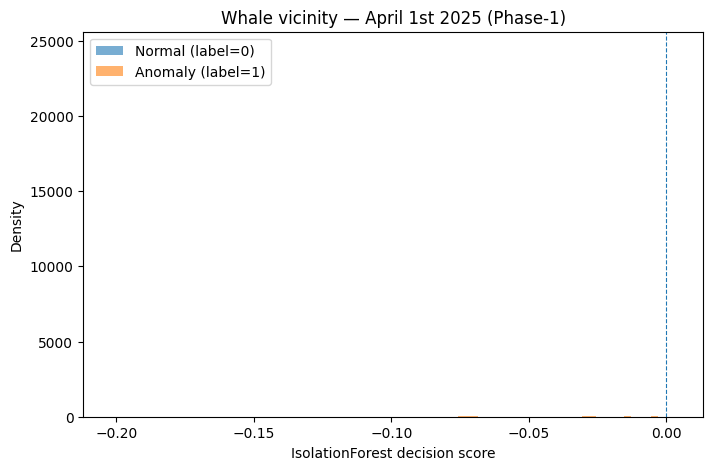

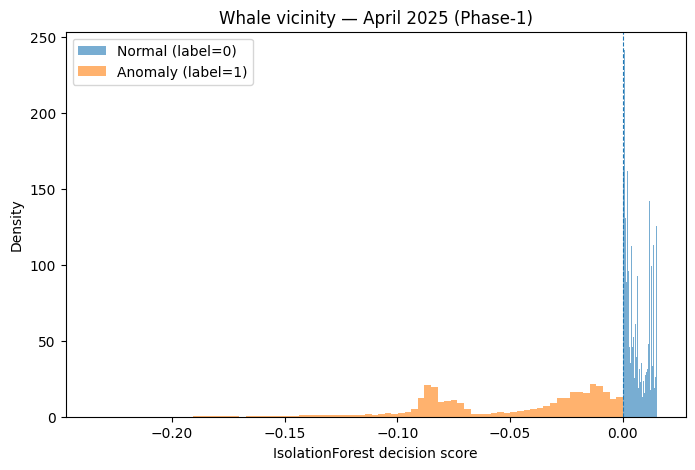

In [11]:

# Plots
plot_hist(sample_apr1, "Whale vicinity — April 1st 2025 (Phase‑1)")
plot_hist(sample_apr,  "Whale vicinity — April 2025 (Phase‑1)")


In [13]:
# Summary
print("—— Phase 1 — Whale Summary Analysis ——\n")
print(prose_for_period("April 1st 2025 (Phase 1)", whale_apr1_stats, global_apr1_stats, sim_apr1))
print()
print(prose_for_period("April 2025 (Phase 1)", whale_apr_stats, global_apr_stats, sim_apr))

# Table 4‑8 with scientific notation for scores
tbl = pd.DataFrame([
    {"Period":"April 1st 2025", "#Tx": whale_apr1_stats.get("n_total"), "Anomaly Rate": whale_apr1_stats.get("anomaly_rate"),
     "Anomaly Min Score": sci(whale_apr1_stats.get("anom_min")), "Anomaly Max Score": sci(whale_apr1_stats.get("anom_max")),
     "Normal Min Score": sci(whale_apr1_stats.get("norm_min")), "Normal Max Score": sci(whale_apr1_stats.get("norm_max")),
     "1−WS Similarity": sim_apr1.get("one_minus_ws"), "WS Distance (norm)": sim_apr1.get("ws"),
     "Separation": sim_apr1.get("word")},
    {"Period":"April 2025", "#Tx": whale_apr_stats.get("n_total"), "Anomaly Rate": whale_apr_stats.get("anomaly_rate"),
     "Anomaly Min Score": sci(whale_apr_stats.get("anom_min")), "Anomaly Max Score": sci(whale_apr_stats.get("anom_max")),
     "Normal Min Score": sci(whale_apr_stats.get("norm_min")), "Normal Max Score": sci(whale_apr_stats.get("norm_max")),
     "1−WS Similarity": sim_apr.get("one_minus_ws"), "WS Distance (norm)": sim_apr.get("ws"),
     "Separation": sim_apr.get("word")},
])

print("\nTable 4‑8 — Whale vicinity stats (Phase‑1)")
print(tbl.to_string(index=False))

#tbl.to_csv("/mnt/data/Table_4_8_Phase1_sci.csv", index=False)
#print("\nSaved: /mnt/data/Table_4_8_Phase1_sci.csv")


—— Phase 1 — Whale Summary Analysis ——

**April 1st 2025 (Phase 1)**
Anomaly rate (whale vicinity): 0.9629  |  Global: 0.0729  |  Lift: 13.2x
Anomaly scores: min -0.2018, max -0.0004
Normal  scores: min 0.0008, max 0.0031
1 − Wasserstein similarity (anomaly vs normal): 0.7336  —  moderate-separation
(normalized WS distance = 0.2664; higher WS ⇒ more separation)
Interpretation: neighbors show behaviors akin to liquidity movements, leading to a concentration of anomaly flags with compressed score bands near the whale.


**April 2025 (Phase 1)**
Anomaly rate (whale vicinity): 0.9389  |  Global: 0.0525  |  Lift: 17.9x
Anomaly scores: min -0.2347, max -0.0000
Normal  scores: min 0.0000, max 0.0154
1 − Wasserstein similarity (anomaly vs normal): 0.7822  —  moderate-separation
(normalized WS distance = 0.2178; higher WS ⇒ more separation)
Interpretation: neighbors show behaviors akin to liquidity movements, leading to a concentration of anomaly flags with compressed score bands near the whale